In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

!ls -l /kaggle/input/traffic-signs-classification

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

total 4456
-rw-r--r--  1 nobody nogroup     863 Oct 30 14:45 extract.py
-rw-r--r--  1 nobody nogroup    1037 Oct 30 14:45 labels.csv
-rw-r--r--  1 nobody nogroup 4552523 Oct 30 14:45 model_trained.p
drwxr-xr-x 45 nobody nogroup       0 Oct 30 14:49 myData


# Importing Libraries

In [2]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics 
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensoFlow Version:  2.12.0


# Reading Data of Class Labels

In [3]:
path = '/kaggle/input/traffic-signs-classification'
lab = pd.read_csv('/kaggle/input/traffic-signs-classification/labels.csv')

# Visualizing CountPlot for the given classes

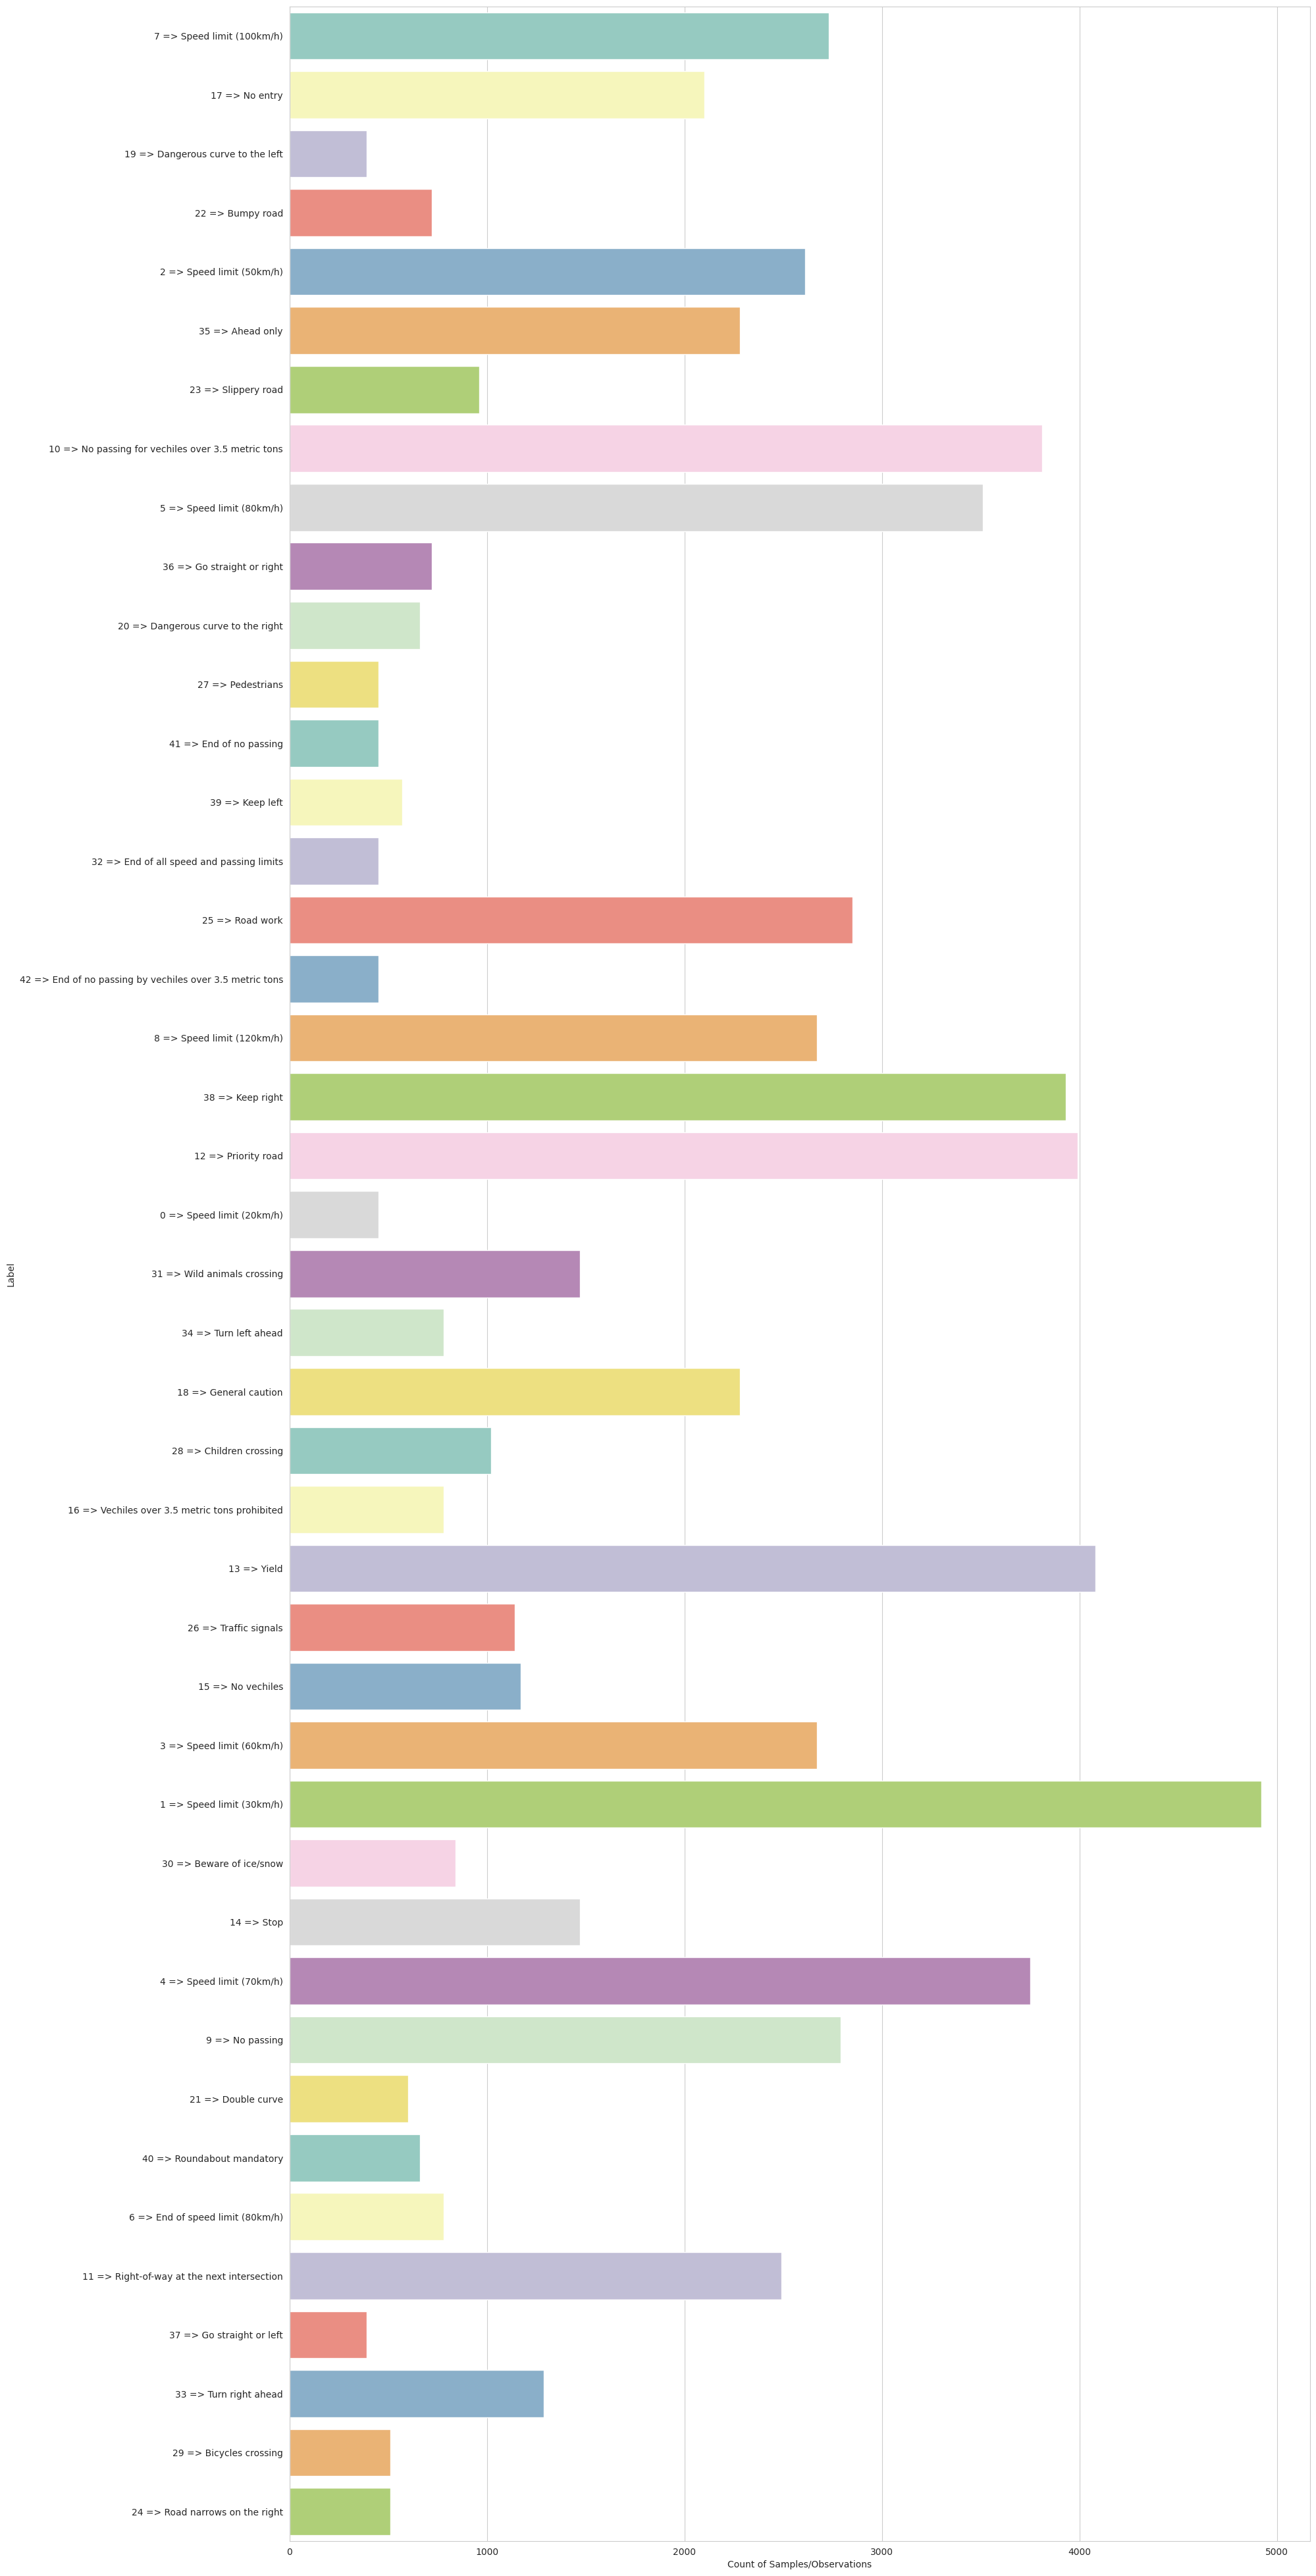

In [4]:
# Count PLot of the samples/observations w.r.t the classes
d = dict()
class_labels = dict()
for dirs in os.listdir(path + '/myData'):
    count = len(os.listdir(path+'/myData/'+dirs))
    d[dirs+' => '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

plt.figure(figsize = (20, 50))
sns.barplot(y = list(d.keys()), x = list(d.values()), palette = 'Set3')
plt.ylabel('Label')
plt.xlabel('Count of Samples/Observations');

# Reading Image Data

In [5]:
# input image dimensions
img_rows, img_cols = 32, 32
# The images are RGB.
img_channels = 3
nb_classes = len(class_labels.keys())

datagen = ImageDataGenerator()
data = datagen.flow_from_directory('/kaggle/input/traffic-signs-classification/myData',
                                    target_size=(32, 32),
                                    batch_size=73139,
                                    class_mode='categorical',
                                    shuffle=True )

Found 73139 images belonging to 43 classes.


In [6]:
X , y = data.next()

In [7]:
# Labels are one hot encoded
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(73139, 32, 32, 3)
Labels shape :(73139, 43)


**Sample Images of the Dataset**

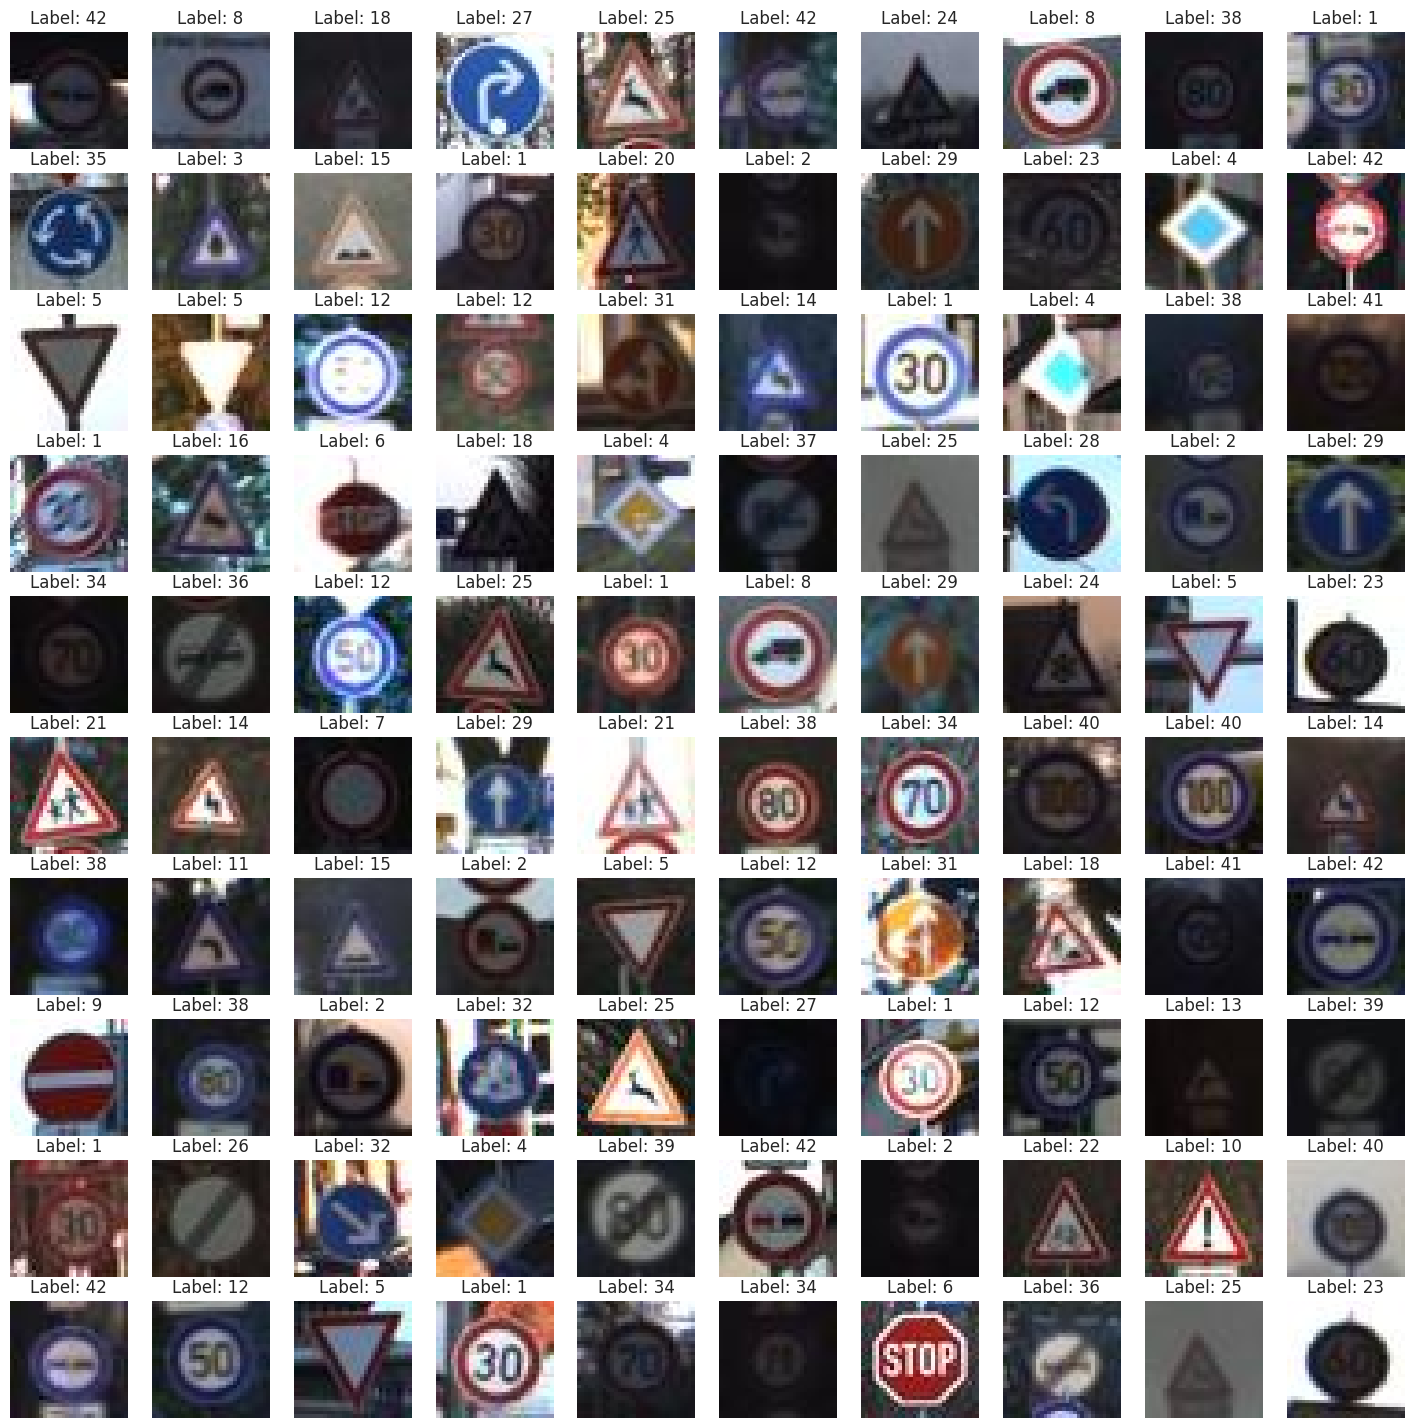

In [8]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))

**Dividing data into *train* and *test* in the split percentage of 80:20**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (58511, 32, 32, 3)
Test Shape : (14628, 32, 32, 3)


# Initializing & Customizing ResNet50 Model

In [10]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,img_channels))

In [11]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

# Visualising Model Architecture

In [13]:
plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

## Compiling the Model

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Creating Callbacks

In [15]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
csv_logger = CSVLogger('train_log.csv', separator=',')

# Fitting Model with Data

In [16]:
n_epochs = 20
history =  model.fit(X_train, y_train,  batch_size = 32, epochs = n_epochs, verbose = 1, 
              validation_data = (X_test, y_test), callbacks = [model_check, early, reduce_lr, csv_logger])

Epoch 1/20
1829/1829 [==============================] - 122s 40ms/step - loss: 3.8954 - accuracy: 0.2042 - val_loss: 3.0026 - val_accuracy: 0.2145 - lr: 0.0010
Epoch 2/20
1829/1829 [==============================] - 72s 40ms/step - loss: 2.8220 - accuracy: 0.3590 - val_loss: 2.2396 - val_accuracy: 0.3374 - lr: 0.0010
Epoch 3/20
1829/1829 [==============================] - 71s 39ms/step - loss: 1.8345 - accuracy: 0.5459 - val_loss: 2.8809 - val_accuracy: 0.4701 - lr: 0.0010
Epoch 4/20
1829/1829 [==============================] - 71s 39ms/step - loss: 0.6426 - accuracy: 0.8087 - val_loss: 0.2696 - val_accuracy: 0.9141 - lr: 0.0010
Epoch 5/20
1829/1829 [==============================] - 75s 41ms/step - loss: 0.3207 - accuracy: 0.9098 - val_loss: 0.1857 - val_accuracy: 0.9428 - lr: 0.0010
Epoch 6/20
1829/1829 [==============================] - 75s 41ms/step - loss: 0.3337 - accuracy: 0.9122 - val_loss: 0.1475 - val_accuracy: 0.9560 - lr: 0.0010
Epoch 7/20
1829/1829 [=======================

### **Saving the model**

In [17]:
model.save('TSC_model.h5')

In [18]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

458/458 [==============================] - 5s 10ms/step - loss: 0.0406 - accuracy: 0.9871
Accuracy:  0.9870795607566833 
Loss    :  0.04056515172123909


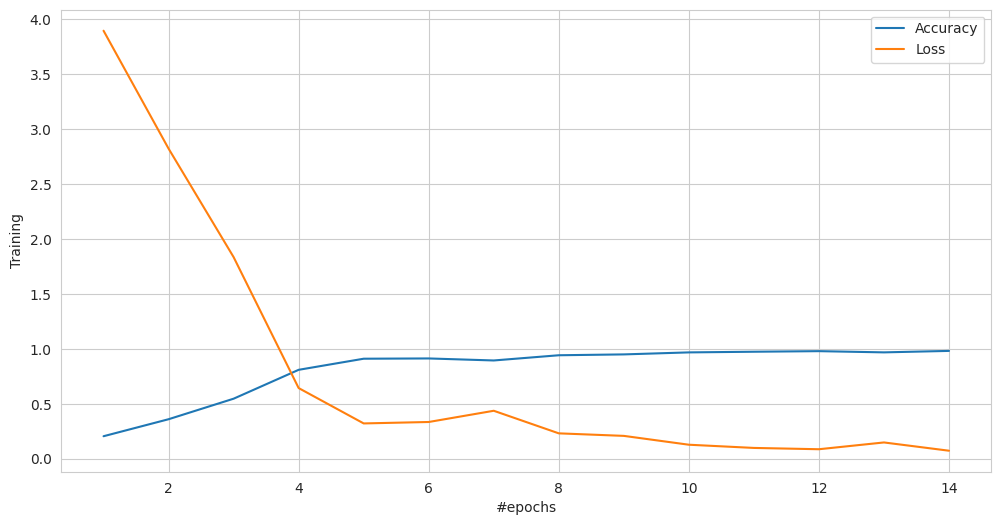

In [19]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

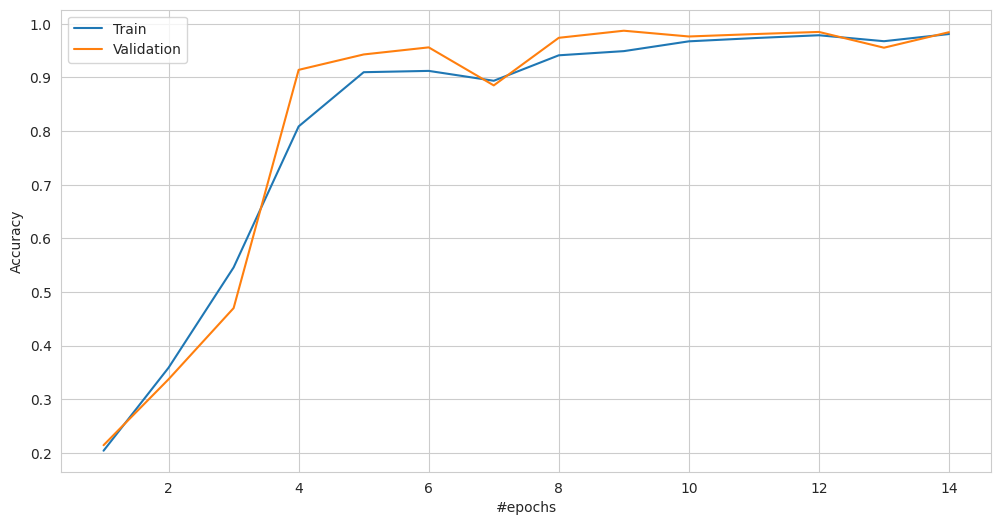

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();

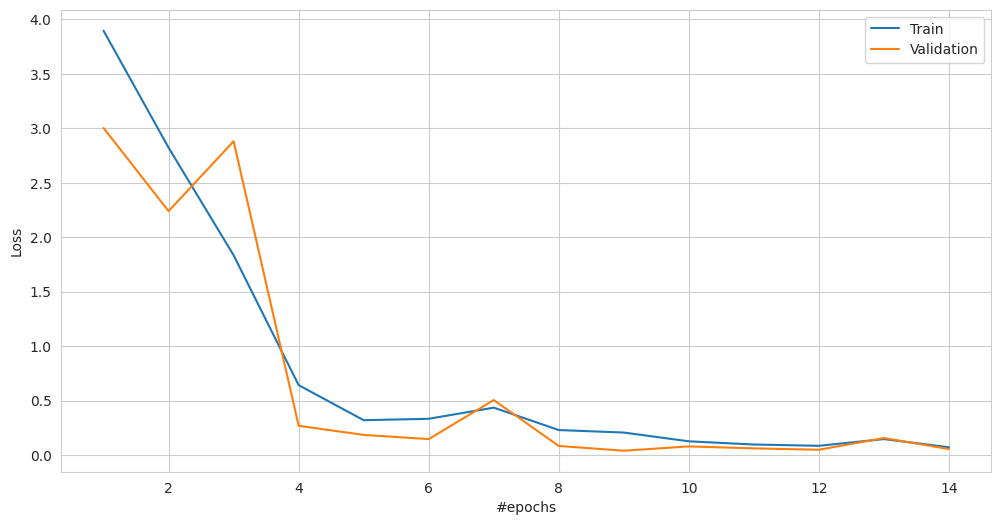

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();

## Predict class labels of the test data

In [22]:
%%time
pred = np.argmax(model.predict(X_test), axis = 1)

458/458 [==============================] - 5s 8ms/step
CPU times: user 5.5 s, sys: 310 ms, total: 5.81 s
Wall time: 5.45 s


## Classification Report

In [23]:
labels = [class_labels[i] for i in range(43)]
print(classification_report(np.argmax(y_test, axis = 1), pred, target_names = labels))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.99      0.93      0.96       101
                              Speed limit (30km/h)       0.97      0.99      0.98       971
                              Speed limit (50km/h)       0.99      1.00      1.00       794
                              Speed limit (60km/h)       0.99      0.99      0.99       542
                              Speed limit (70km/h)       1.00      1.00      1.00       803
                              Speed limit (80km/h)       1.00      1.00      1.00       847
                       End of speed limit (80km/h)       1.00      0.99      1.00       283
                             Speed limit (100km/h)       0.97      1.00      0.98       226
                             Speed limit (120km/h)       0.99      1.00      1.00       153
                                        No passing       1.00      1.00      1.

## Confusion Matrix

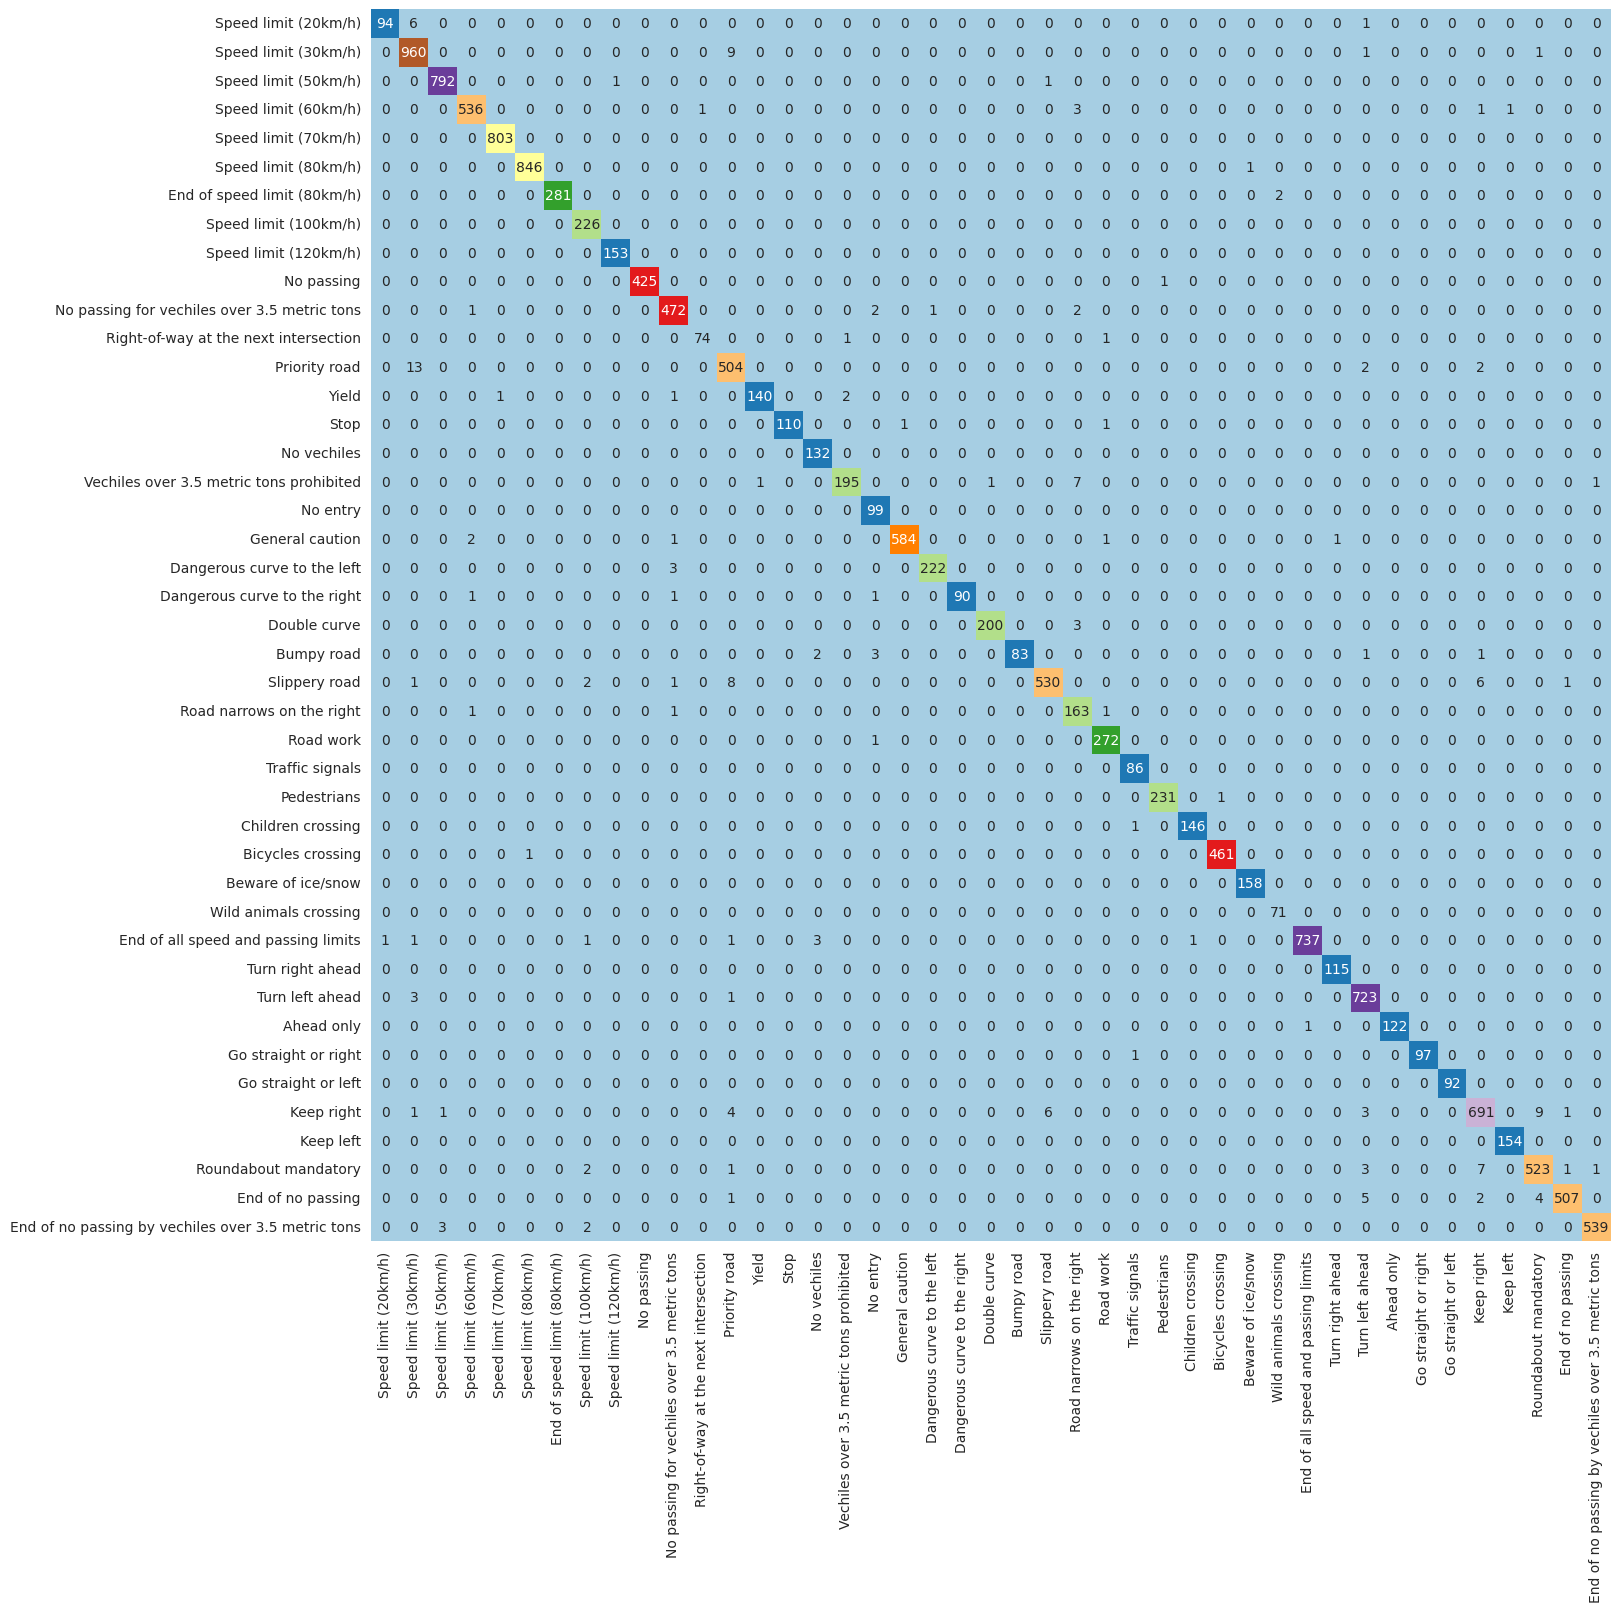

In [24]:
cmat = confusion_matrix(np.argmax(y_test, axis=1), pred)
plt.figure(figsize=(16,16))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Paired', fmt="d", xticklabels=labels, yticklabels=labels);

## Classwise Accuracy

In [26]:
classwise_acc = cmat.diagonal() / cmat.sum(axis=1) * 100 
cls_acc = pd.DataFrame({'Class_Label': [class_labels[i] for i in range(43)], 'Accuracy': classwise_acc.tolist()}, columns=['Class_Label', 'Accuracy'])
cls_acc.set_index('Class_Label', inplace=True)  # Set the index to 'Class_Label'
cls_acc.style.format({"Accuracy": "{:,.2f}"}).bar(subset=["Accuracy"], color='tomato')

# Predictions of unseen data

1/1 [==============================] - 0s 24ms/step


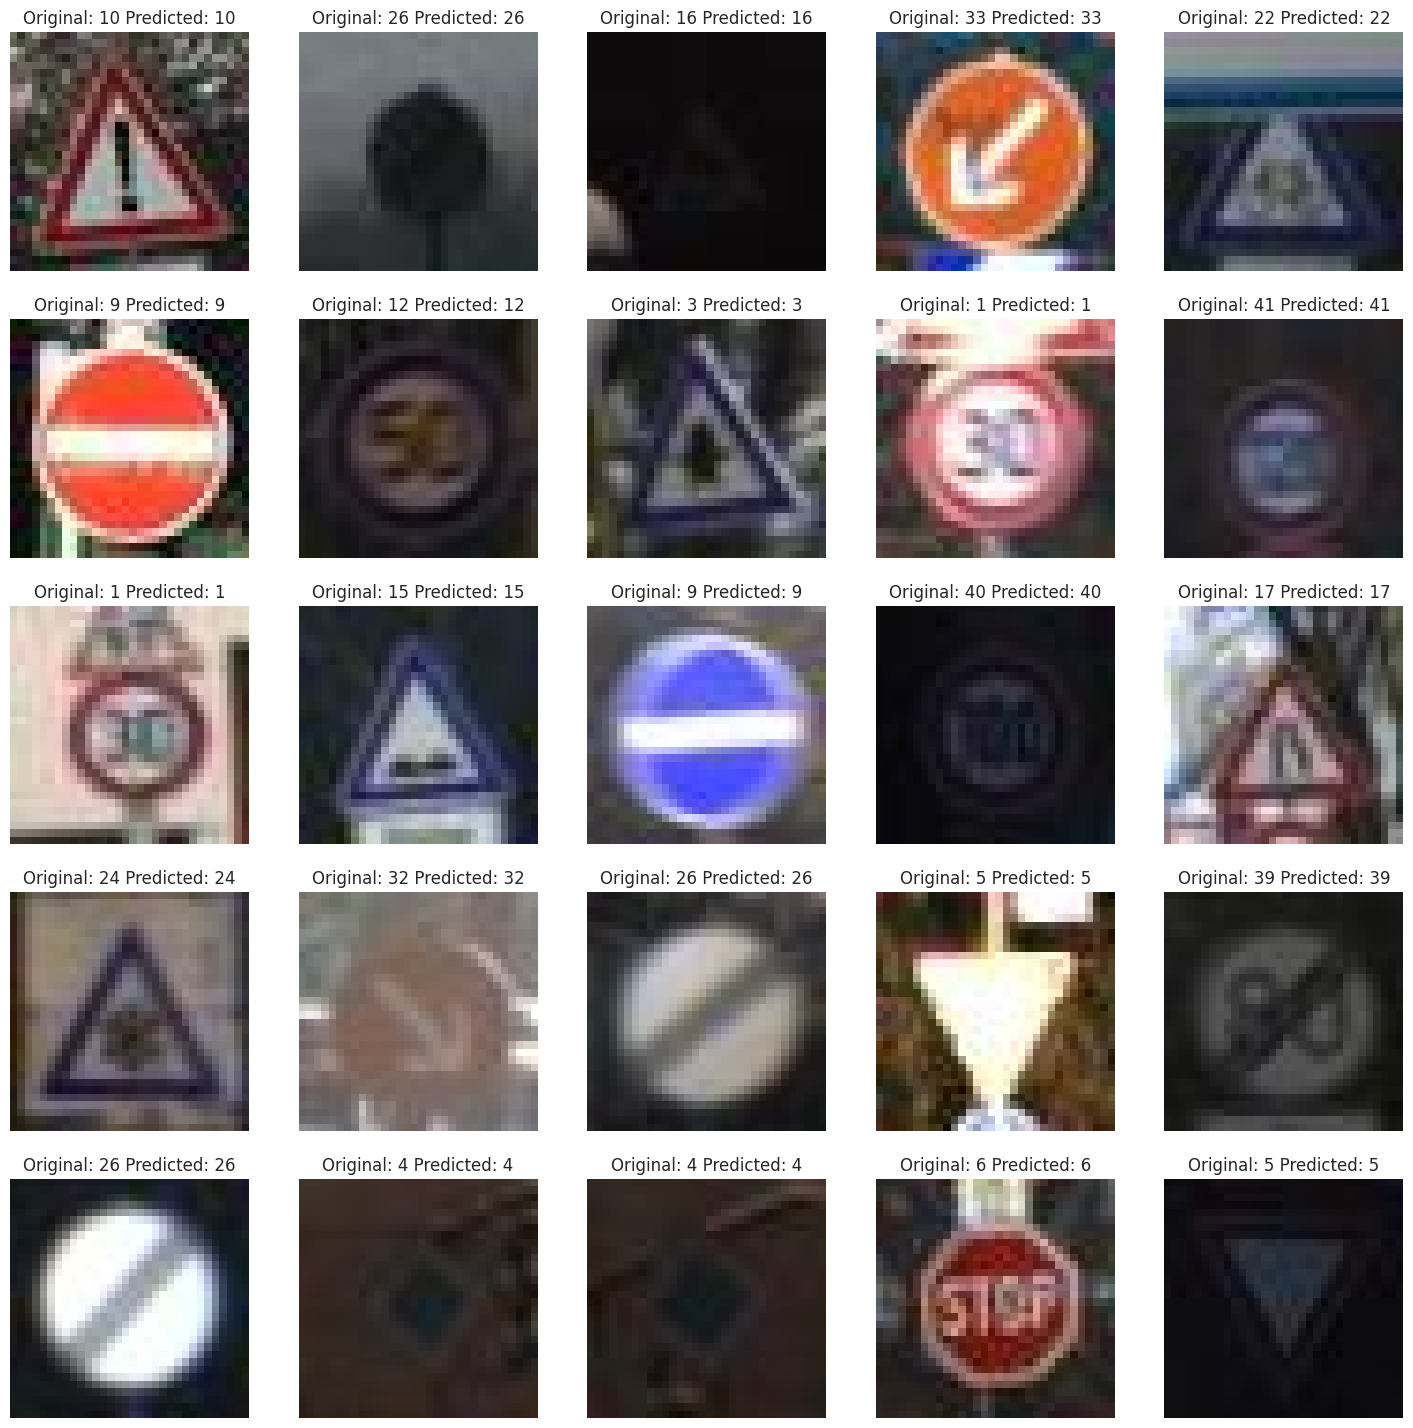

In [27]:
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))